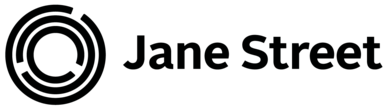
# Jane Street Market Prediction

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import janestreet
env = janestreet.make_env() # initialize the environment
iter_test = env.iter_test() # an iterator which loops over the test set

In [ ]:
train_dataset = pd.read_csv('../input/jane-street-market-prediction/train.csv', nrows=100000)
train_dataset.head()

In [ ]:
train_dataset.info(verbose=True, null_counts=True)

In [ ]:
len(train_dataset)

In [ ]:
#remove rows where weight = 0
train_dataset_weight = train_dataset[train_dataset.weight != 0]
train_dataset_weight['action'] = ((train_dataset_weight['weight'].values * train_dataset_weight['resp'].values) > 0).astype('int')
train_dataset_weight.head()


In [ ]:
#Looking for good and bad days
sum_days = pd.DataFrame(train_dataset_weight, columns = ["date","resp"])
sum_days = sum_days.groupby("date", as_index=False).sum()

#good days

good_days= sum_days[sum_days.resp >= 0]
bad_days = sum_days[sum_days.resp < 0]



#    What bad days have in commom and what good days have in commom ?????

In [ ]:
good_days_comp = train_dataset_weight.loc[train_dataset_weight['date'].isin(good_days['date'])]
bad_days_comp = train_dataset_weight.loc[train_dataset_weight['date'].isin(bad_days['date'])]

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Trades in bad days', 'Trades in Good days']
students = [len(bad_days_comp),len(good_days_comp)]
ax.bar(langs,students)
plt.show()

In [ ]:

good_days_comp['feature_80'].hist(bins=80, figsize=[3,3])
bad_days_comp['feature_80'].hist(bins=80, figsize=[3,3])
plt.axvline(x=good_days_comp['feature_80'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=bad_days_comp['feature_80'].mean(), color='g', linestyle='dashed', linewidth=2)

In [ ]:
#Plot showing the number of features x accuracy
plt.plot(sum_days['date'],sum_days['resp'].cumsum(),drawstyle='steps-mid')
plt.ylabel('Resp')
plt.xlabel('Days')
plt.show()

In [ ]:
bad_trades = train_dataset_weight.query("resp < 0")
good_trades = train_dataset_weight.query("resp >= 0")


for i in good_trades.columns:
    good_trades[i].hist(bins=80, figsize=[5,5])
    bad_trades[i].hist(bins=80, figsize=[5,5],alpha = 0.7)
    plt.axvline(x=good_trades[i].mean(), color='r', linestyle='dashed', linewidth=2)
    plt.axvline(x=bad_trades[i].mean(), color='g', linestyle='dashed', linewidth=2)
    plt.title(i)
    plt.autoscale() 
    plt.show()
    
    

In [ ]:
from sklearn.impute import SimpleImputer

# Imputation
my_imputer = SimpleImputer(strategy='mean')

imputed_train_dataset_weight = pd.DataFrame(my_imputer.fit_transform(train_dataset_weight))

imputed_train_dataset_weight.columns = train_dataset_weight.columns

imputed_train_dataset_weight


In [ ]:
#Check correlation in the dataset

#sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = bad_days_comp.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(35, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
#Creating X, y dataset
y = imputed_train_dataset_weight.action
X = imputed_train_dataset_weight.drop(['action', 'date',	'weight',	'resp_1',	'resp_2',	'resp_3',	'resp_4',	'resp', 'ts_id'], axis=1)

In [ ]:
# Divide data into training and validation subsets
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [ ]:
X_train

In [ ]:
#Feature selsction using SelectPercentile
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

my_model = XGBClassifier(n_estimators=500,n_jobs=2, tree_method = 'gpu_hist')

accuracy = []

#for i in range(1, 131, 1):
 #   X_new = SelectKBest(k=i).fit_transform(X, y)
  #  print('Numero de features mais significantes = ', i)
   # X_train, X_valid, y_train, y_valid = train_test_split(X_new, y, train_size=0.8, test_size=0.2, random_state=0)
    #print(my_model.fit(X_train, y_train, 
     #        early_stopping_rounds=50, 
      #       eval_set=[(X_valid, y_valid)], verbose=False))
    
   # predict = my_model.predict(X_valid)
   # accur = accuracy_score(y_valid, predict, normalize=False)
   # accuracy.append(accur)
   # print("Accur = ", 100*(accur/len(y_valid)))
   # print("  ")
   # print("---------------------------------------------------")
   # print("  ")
    
    

In [ ]:
#Plot showing the number of features x accuracy
#calcula = [(100*((accuracy[i])/len(y_valid))) for i in range(len(accuracy))]
#plt.plot(calcula)
#plt.ylabel('Accuracy')
#plt.xlabel('Numero de features')
#plt.show()
#calcula.index(max(calcula))

In [ ]:
selector = SelectKBest(k=118)
X_new = selector.fit_transform(X, y)
selected_features = pd.DataFrame(selector.inverse_transform(X_new), 
                                 index=X.index, 
                                 columns=X.columns)

In [ ]:
selected_features.head()

In [ ]:
selected_columns = selected_features.columns[selected_features.var() != 0]
selected_columns

In [ ]:
X_model = imputed_train_dataset_weight[selected_columns]

In [ ]:
my_model.fit(X_model,y)

In [ ]:
for (test_df, sample_prediction_df) in iter_test:
    X_test = test_df.loc[:, selected_columns]
    #Predict Target
    y_preds = my_model.predict(X_test)
    sample_prediction_df.action = y_preds
    env.predict(sample_prediction_df)